In [1]:
import os
import numpy as np
import shutil
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#Preprocessing data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset yang digunakan berasal dari berikut:
https://www.kaggle.com/datasets/muhammadardiputra/potato-leaf-disease-dataset 

## Pengaturan direktori train, val, test

In [3]:
base_dir = '/content/drive/MyDrive/Data/potato_dataset'

train_dir = '/content/drive/MyDrive/Data/potato_dataset/Training'
test_dir = '/content/drive/MyDrive/Data/potato_dataset/Testing'
val_dir = '/content/drive/MyDrive/Data/potato_dataset/Validation'

In [4]:
BATCH_SIZE=32
IMAGE_SIZE=256

dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                     shuffle=True,
                                                     batch_size = BATCH_SIZE,
                                                     image_size = (IMAGE_SIZE,IMAGE_SIZE))

Found 3260 files belonging to 3 classes.


In [5]:
classes = dataset.class_names
classes

['Early_Blight', 'Healthy', 'Late_Blight']

## Display images

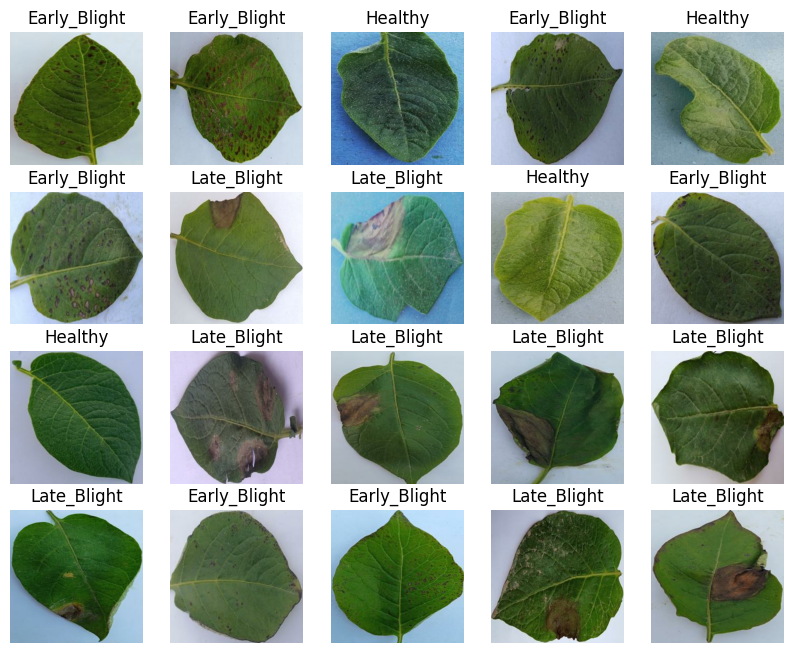

In [6]:
plt.figure(figsize=(10,10))
for image,label in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(classes[label[i]])
        plt.axis("off")

#Data augmentasi 

In [7]:
# Train generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical')

# Validation generator
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical')

#Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 3260 images belonging to 3 classes.
Found 416 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


#Fungsi awal

In [8]:
##..........................
# direktori saved model
##..........................
saved_model_dir = "/content/saved_model"
saved_model_his = "/content/saved_model_history"

os.mkdir(saved_model_dir)
os.mkdir(saved_model_his)


In [9]:
##..........................
# simpan model
##..........................

import pickle

# simpan saved model
def saved_model(model, modelname):
  export_path = os.path.join(saved_model_dir, modelname)
  if os.path.isdir(export_path):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(export_path, ignore_errors=True)

  model.save(export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# simpan model history
def saved_model_history(history, modelname):
  with open(os.path.join(saved_model_his, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [10]:
from google.colab import files
os.mkdir("/content/modelh5")
saved_model_h5 = "/content/modelh5"

def savedh5(model, model_name):
    model_dir = os.path.join(saved_model_h5, model_name)
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, model_name + ".h5")
    model.save(model_path)
    files.download(model_path)
    print("Model berhasil disimpan di:", model_path)

In [11]:
##..........................
#learning curve
##..........................

def plot_learning_curves(history):
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]

  epochs   = range(len(acc)) 


  plt.plot  ( epochs,     acc, label='Training')
  plt.plot  ( epochs, val_acc, label='Validation')
  plt.title ('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot  ( epochs,     loss, label='Training')
  plt.plot  ( epochs, val_loss, label='Validation')
  plt.legend()
  plt.title ('Training and validation loss')

In [12]:
##..........................
#Confudion matrix
##..........................

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def cf_matrix(model):
    # Memprediksi label menggunakan model
    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)

    # Mendapatkan label sebenarnya dari test_generator
    y_true = test_generator.classes

    # Menghitung matriks kebingungan
    cm = confusion_matrix(y_true, y_pred)

    # Mendapatkan nama kelas dari test_generator
    class_names = list(test_generator.class_indices.keys())

    # Visualisasi matriks kebingungan dalam bentuk heatmap
    plt.figure(figsize=(8, 6), dpi=100)
    plt.subplot(2, 1, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Membuat laporan klasifikasi
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)


# Model 1 | CNN

In [13]:
input_shape = (256, 256, 3)
n_classes = 3

model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model1.build(input_shape=input_shape)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [14]:
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer="adam",
              metrics=['accuracy'])

In [15]:
# Train the model
history1 = model1.fit(train_generator,
                    batch_size=32,
                    validation_data = val_generator,
                    verbose = 1, 
                    validation_steps=3,
                    epochs=50
                    )

Epoch 1/50
102/102 [==============================] - 424s 4s/step - loss: 1.0232 - accuracy: 0.4460 - val_loss: 0.7430 - val_accuracy: 0.6458
Epoch 2/50
102/102 [==============================] - 84s 825ms/step - loss: 0.7938 - accuracy: 0.6298 - val_loss: 0.6190 - val_accuracy: 0.7188
Epoch 3/50
102/102 [==============================] - 76s 747ms/step - loss: 0.6151 - accuracy: 0.7583 - val_loss: 0.3914 - val_accuracy: 0.8854
Epoch 4/50
102/102 [==============================] - 74s 729ms/step - loss: 0.4138 - accuracy: 0.8399 - val_loss: 0.3232 - val_accuracy: 0.8750
Epoch 5/50
102/102 [==============================] - 65s 640ms/step - loss: 0.2898 - accuracy: 0.8972 - val_loss: 0.2813 - val_accuracy: 0.9062
Epoch 6/50
102/102 [==============================] - 67s 662ms/step - loss: 0.2530 - accuracy: 0.9064 - val_loss: 0.1210 - val_accuracy: 0.9688
Epoch 7/50
102/102 [==============================] - 59s 576ms/step - loss: 0.2112 - accuracy: 0.9267 - val_loss: 0.1998 - val_accu

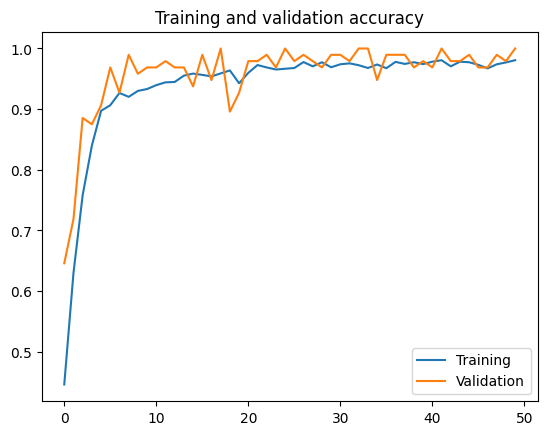

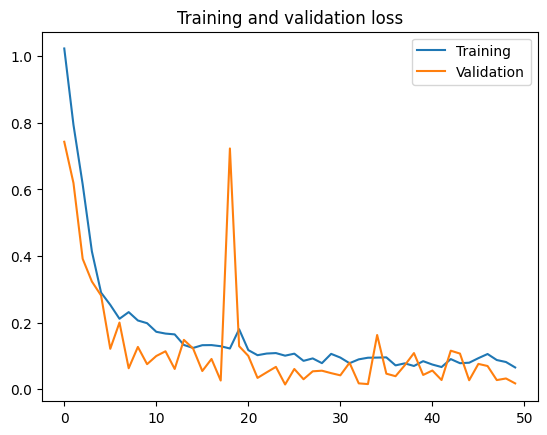

In [16]:
# learning curve
plot_learning_curves(history1)

7/7 [==============================] - 106s 17s/step


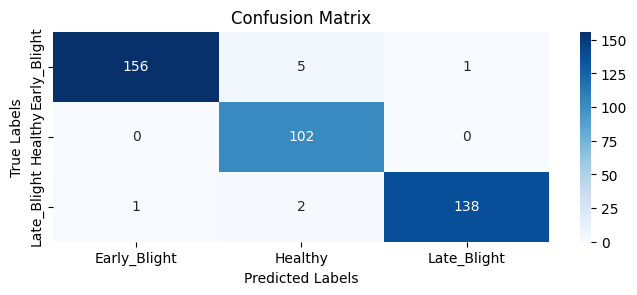

              precision    recall  f1-score   support

Early_Blight       0.99      0.96      0.98       162
     Healthy       0.94      1.00      0.97       102
 Late_Blight       0.99      0.98      0.99       141

    accuracy                           0.98       405
   macro avg       0.97      0.98      0.98       405
weighted avg       0.98      0.98      0.98       405



In [17]:
# cf matrix
cf_matrix(model1)

In [18]:
savedh5(model1, "model1")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model berhasil disimpan di: /content/modelh5/model1/model1.h5


In [19]:
saved_model(model1, "model1")
saved_model_history(model1, "history1")

Export path:  /content/saved_model/model1
['assets', 'saved_model.pb', 'fingerprint.pb', 'variables', 'keras_metadata.pb']


#Model 2 | NasNet

In [30]:
base_model=tf.keras.applications.NASNetMobile(include_top=False, weights="imagenet",input_shape=(256,256,3))

19993432/19993432 [==============================] - 0s 0us/step


In [ ]:
#base_model.summary()

In [ ]:
base_model.trainable = False

model2 = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(3, activation='softmax')
])

model2.build(input_shape=(32,256,256,3))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 8, 8, 1056)        4269716   
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 32)          304160    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 32)          0         
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                      

In [ ]:
opt = Adam(learning_rate=0.001)

model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
# Train the model
history2 = model2.fit(train_generator,
                    batch_size=20,
                    validation_data = val_generator,
                    verbose = 1, 
                    validation_steps=3,
                    epochs=50
                    )

Epoch 1/50
102/102 [==============================] - 78s 618ms/step - loss: 0.6932 - accuracy: 0.7497 - val_loss: 0.3032 - val_accuracy: 0.8750
Epoch 2/50
102/102 [==============================] - 58s 565ms/step - loss: 0.3516 - accuracy: 0.8626 - val_loss: 0.3481 - val_accuracy: 0.8750
Epoch 3/50
102/102 [==============================] - 59s 576ms/step - loss: 0.3211 - accuracy: 0.8819 - val_loss: 0.3115 - val_accuracy: 0.8438
Epoch 4/50
102/102 [==============================] - 58s 561ms/step - loss: 0.2758 - accuracy: 0.9021 - val_loss: 0.2422 - val_accuracy: 0.8854
Epoch 5/50
102/102 [==============================] - 58s 567ms/step - loss: 0.2695 - accuracy: 0.8982 - val_loss: 0.1518 - val_accuracy: 0.9271
Epoch 6/50
102/102 [==============================] - 58s 571ms/step - loss: 0.2492 - accuracy: 0.9110 - val_loss: 0.2306 - val_accuracy: 0.9375
Epoch 7/50
102/102 [==============================] - 58s 569ms/step - loss: 0.2160 - accuracy: 0.9233 - val_loss: 0.2409 - val_ac

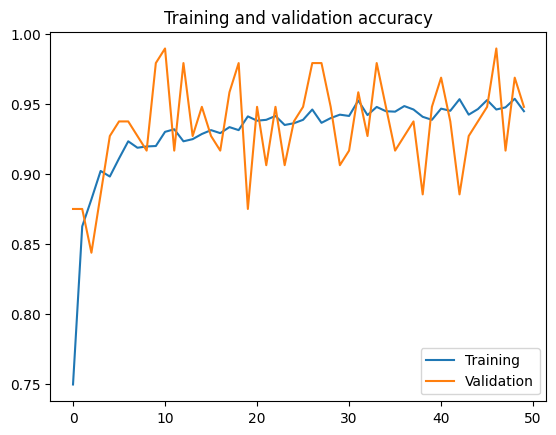

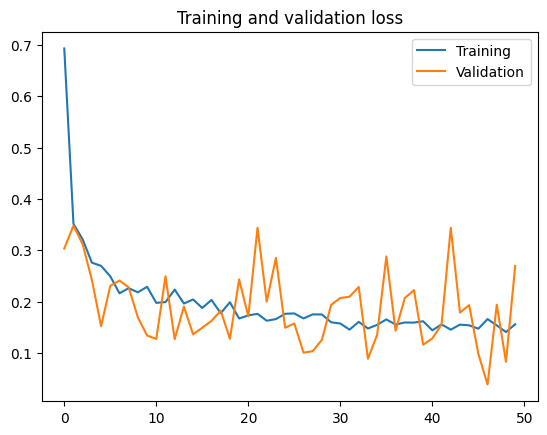

In [ ]:
plot_learning_curves(history2)

7/7 [==============================] - 8s 341ms/step


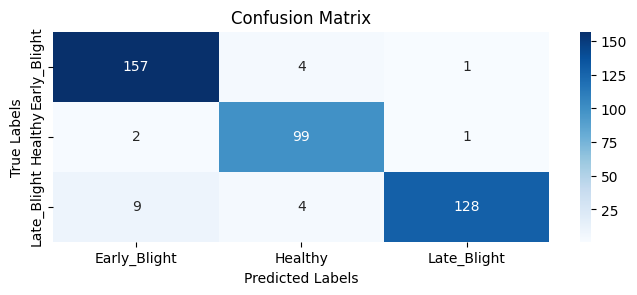

              precision    recall  f1-score   support

Early_Blight       0.93      0.97      0.95       162
     Healthy       0.93      0.97      0.95       102
 Late_Blight       0.98      0.91      0.94       141

    accuracy                           0.95       405
   macro avg       0.95      0.95      0.95       405
weighted avg       0.95      0.95      0.95       405



In [ ]:
#cf matrix
cf_matrix(model2)

In [ ]:
savedh5(model2, "model2")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model berhasil disimpan di: /content/modelh5/model2/model2.h5


In [ ]:
saved_model(model2, "model2")
saved_model_history(model2, "history2")

Export path:  /content/saved_model/model2
['fingerprint.pb', 'variables', 'assets', 'keras_metadata.pb', 'saved_model.pb']


# Model 3 | VG16


In [ ]:
categories = list(train_generator.class_indices.keys())
print(val_generator.class_indices)

{'Early_Blight': 0, 'Healthy': 1, 'Late_Blight': 2}


In [ ]:
base_model3 = tf.keras.applications.VGG16(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (256, 256, 3) 
                                                )

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model3.trainable = False

model3 = tf.keras.Sequential([
            base_model3,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(3, activation='softmax')
])

model3.build(input_shape=(32,256,256,3))
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 4, 32)          0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                        

In [ ]:
model3.compile(optimizer = 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

In [ ]:
# Train the model
history3 = model3.fit(train_generator,
                    batch_size=20,
                    validation_data = val_generator,
                    verbose = 1, 
                    validation_steps=3,
                    epochs=15
                    )

Epoch 1/15
102/102 [==============================] - 918s 9s/step - loss: 0.9806 - accuracy: 0.4979 - val_loss: 0.6894 - val_accuracy: 0.7396
Epoch 2/15
102/102 [==============================] - 96s 943ms/step - loss: 0.6798 - accuracy: 0.7104 - val_loss: 0.6888 - val_accuracy: 0.6875
Epoch 3/15
102/102 [==============================] - 83s 810ms/step - loss: 0.5851 - accuracy: 0.7518 - val_loss: 0.5029 - val_accuracy: 0.8021
Epoch 4/15
102/102 [==============================] - 75s 739ms/step - loss: 0.4870 - accuracy: 0.8006 - val_loss: 0.5028 - val_accuracy: 0.7917
Epoch 5/15
102/102 [==============================] - 73s 718ms/step - loss: 0.4684 - accuracy: 0.8166 - val_loss: 0.4355 - val_accuracy: 0.8229
Epoch 6/15
102/102 [==============================] - 70s 685ms/step - loss: 0.4379 - accuracy: 0.8221 - val_loss: 0.3918 - val_accuracy: 0.8229
Epoch 7/15
102/102 [==============================] - 70s 679ms/step - loss: 0.4160 - accuracy: 0.8353 - val_loss: 0.2268 - val_accu

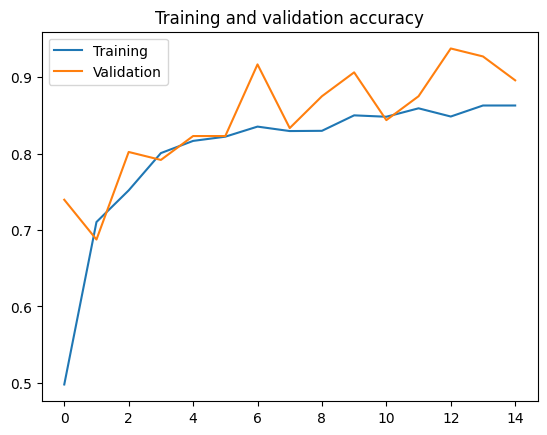

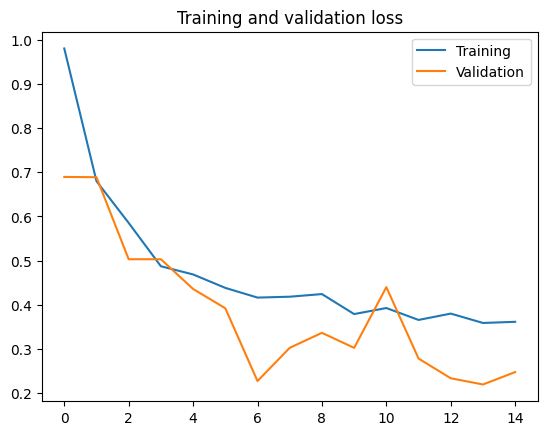

In [ ]:
plot_learning_curves(history3)

7/7 [==============================] - 124s 19s/step


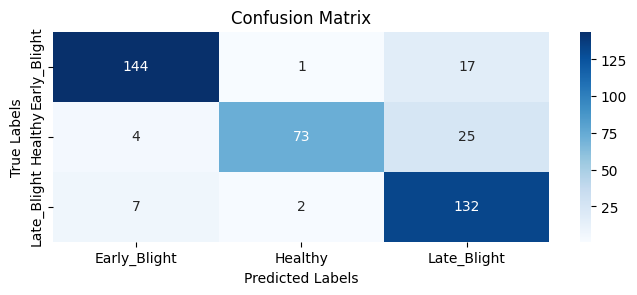

              precision    recall  f1-score   support

Early_Blight       0.93      0.89      0.91       162
     Healthy       0.96      0.72      0.82       102
 Late_Blight       0.76      0.94      0.84       141

    accuracy                           0.86       405
   macro avg       0.88      0.85      0.86       405
weighted avg       0.88      0.86      0.86       405



In [ ]:
cf_matrix(model3)

Dengan mempertimbangkan angka akurasi dan loss kita memilih model 1 atau basic CNN

#Function for inference

In [57]:
# Upload gambar
uploaded = files.upload()
class_names = list(val_generator.class_indices.keys())

for fn in uploaded.keys():
  # Edit gambar input
  path = fn
  img = np.array(Image.open(path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE)))
  img = img / 255
  img_array = tf.expand_dims(img, 0)

  # Prediksi gambar
  classes = model1.predict(img_array)

  predicted_class_index = np.argmax(classes)
  predicted_class = class_names[predicted_class_index]
  confidence_level = classes[0][predicted_class_index] * 100

  print(fn)
  print("Gambar ini adalah", predicted_class)
  print("Confidence:", confidence_level, "%")

Saving Early_Blight_21.jpg to Early_Blight_21.jpg
1/1 [==============================] - 0s 20ms/step
Early_Blight_21.jpg
Gambar ini adalah Early_Blight
Confidence: 99.99175071716309 %


## Pembuktian menggunakan test dataset

In [79]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
    

1/1 [==============================] - 0s 36ms/step


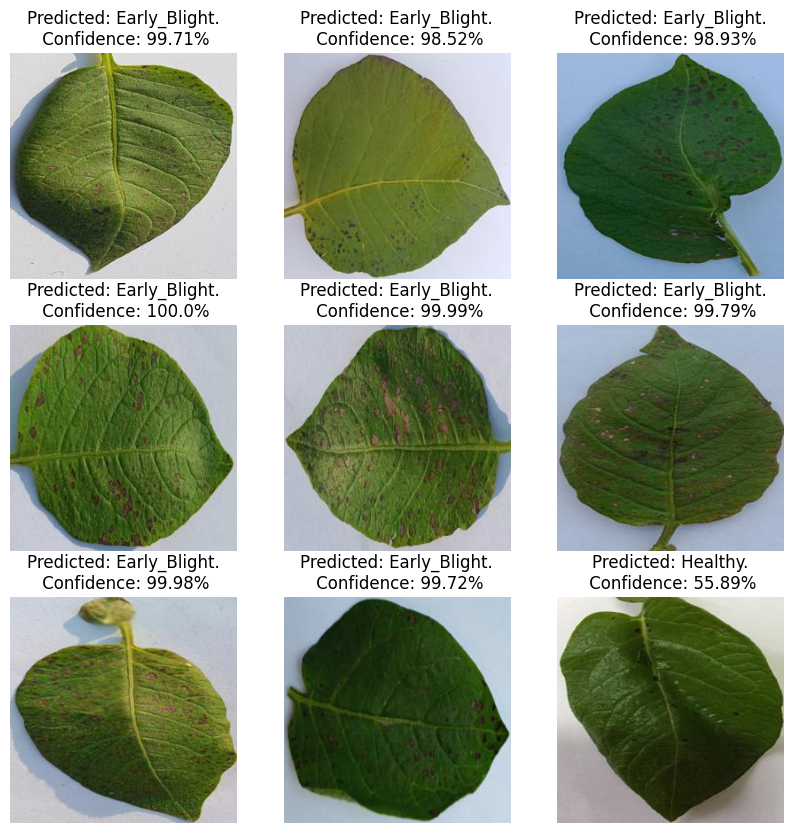

In [82]:
plt.figure(figsize=(10, 10))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model1, images[i])
        
        plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break